# Experiment 1. Cheetah


## Setup


In [1]:
import math
from datetime import datetime

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import numpy as np
import torch
from mujoco_playground import registry
from mujoco_playground import wrapper_torch
from rsl_rl.runners import OnPolicyRunner

import drl_options
from drl_options.ext.train_rsl_rl import get_rl_config
from drl_options.ext.rsl_rl_utils import make_progress_plotter, setup_rsl_runner

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
env = registry.load("CheetahRun")
env

In [4]:
env_cfg = registry.get_default_config("CheetahRun")
env_cfg

# rsl_cfg = get_rl_config("CheetahRun")
# rsl_cfg

action_repeat: 1
ctrl_dt: 0.01
episode_length: 1000
sim_dt: 0.01
vision: false

In [5]:
TASK = "CheetahRun"

### Random Rollout Test


In [6]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]

frequency_hz = 0.5
for _ in range(env_cfg.episode_length):
    action = [
        jp.sin(
            state.data.time * 2 * jp.pi * frequency_hz + j * 2 * jp.pi / env.action_size
        )
        for j in range(env.action_size)
    ]
    state = jit_step(state, jp.array(action))
    rollout.append(state)

frames = env.render(rollout)
media.show_video(frames, fps=1.0 / env.dt)

100%|██████████| 1001/1001 [00:00<00:00, 1101.37it/s]


## Train


### PPO (Baseline)


In [7]:
seed = 1
num_envs = 1024
num_steps_per_env = 32
max_iterations = 200

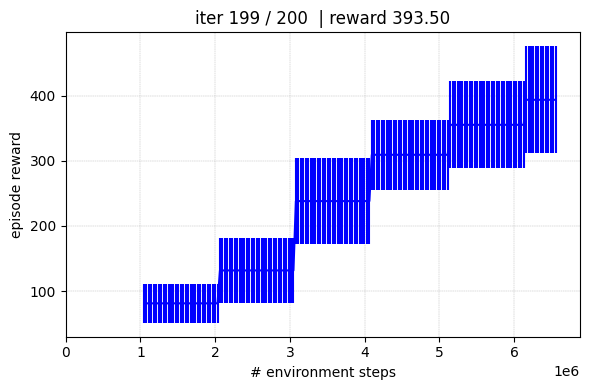

Training finished in 0:00:59.569044. Logs stored at: logs/dm_control_rsl/CheetahRun-20251024-213816
Final reward: 393.50 +/- 82.31


In [9]:
seed = 1
num_envs = 1024
num_steps_per_env = 32
max_iterations = 200

estimated_total_steps = max_iterations * num_envs * num_steps_per_env
progress_cb, steps, rewards, reward_stds, timestamps = make_progress_plotter(
    estimated_total_steps
)

runner, env_cfg, logdir, device = setup_rsl_runner(
    TASK,
    seed=seed,
    num_envs=num_envs,
    num_steps_per_env=num_steps_per_env,
    max_iterations=max_iterations,
    progress_callback=progress_cb,
)

train_start = datetime.now()
runner.learn(max_iterations, init_at_random_ep_len=False)
train_end = datetime.now()

training_duration = train_end - train_start
final_metrics = runner.progress_history[-1] if runner.progress_history else {}

print(f"Training finished in {training_duration}. Logs stored at: {logdir}")
if final_metrics and math.isfinite(final_metrics.get("episode_reward_mean", float("nan"))):
  print(
      f"Final reward: {final_metrics['episode_reward_mean']:.2f} "
      f"+/- {final_metrics['episode_reward_std']:.2f}"
  )

last_runner = runner
last_env_cfg = env_cfg
last_env_name = TASK
last_device = device
last_progress = {
    "steps": steps,
    "rewards": rewards,
    "reward_stds": reward_stds,
    "timestamps": timestamps,
    "logdir": logdir,
}

In [11]:
if last_runner is None or last_env_cfg is None or last_env_name is None:
  raise RuntimeError("Run the training cell first to obtain a trained policy.")

eval_env = registry.load(last_env_name, config=last_env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
policy = last_runner.get_inference_policy(device=last_device)

rng = jax.random.PRNGKey(seed)
state = jit_reset(rng)
rollout = [state]

def _extract_obs(obs):
  if isinstance(obs, dict):
    return obs["state"]
  return obs

obs_torch = wrapper_torch._jax_to_torch(_extract_obs(state.obs))

for _ in range(last_env_cfg.episode_length):
  with torch.no_grad():
    action = policy(obs_torch)
  state = jit_step(state, wrapper_torch._torch_to_jax(action.flatten()))
  rollout.append(state)
  obs_torch = wrapper_torch._jax_to_torch(_extract_obs(state.obs))
  if bool(np.array(state.done)):
    break

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False

render_every = 1
frames = eval_env.render(
    rollout[::render_every],
    # camera="fixed",
    height=480,
    width=640,
    scene_option=scene_option,
)
media.show_video(frames, fps=1.0 / eval_env.dt / render_every)

100%|██████████| 1001/1001 [00:01<00:00, 806.02it/s]


### Option-Critic


### Double Actor Critic


## Comparison
